In [18]:
import numpy as np
import pandas as pd
import matplotlib as plt
import urllib.request
from pulp import *
from IPython.display import Image, display_png
from IPython.core.display import display, HTML
import seaborn as sns

display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

In [2]:
t = pd.read_csv('../csv/stochastic_matrix.csv', index_col=0).fillna(0)

In [3]:
v = t.T[[
    'R01786','R02740','R04779','R01070','R01061','R01512','R01518','R00658',
    'R00200','R01196','R00351','R00341','R01325','R01900','R01899','R00268',
    'R01197','R00405','R02164','R01082','R00342','R01015','R00703','R02035',
    'R01528','R01056','R01049','R01529','R01641'
]].T

for i in v.columns:
    if sum(v[i] == 0) == v.shape[0]:
        v = v.drop(i, axis=1)
        
v['C00007'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00033'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00092'] = pd.Series(np.zeros(v.shape[0]), index=v.index)
v['C00279'] = pd.Series(np.zeros(v.shape[0]), index=v.index)

In [4]:
df = v.T
df['Glucose'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Glucose']['C00267'] = 1

df['Oxygen'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Oxygen']['C00007'] = 1

df['CO2'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['CO2']['C00011'] = -1

df['Lactate'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Lactate']['C00186'] = -1

df['Succinate'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Succinate']['C00042'] = -1

df['Malate'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Malate']['C00149'] = -1

df['Fumarate'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Fumarate']['C00122'] = -1

df['Acetate'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Acetate']['C00033'] = -1

df['Glu_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Glu_Exchange']['C00267'] = -1
df['Glu_Exchange']['C00092'] = 1

df['acetyl_CoA_hydrolase'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['acetyl_CoA_hydrolase']['C00024'] = -1
df['acetyl_CoA_hydrolase']['C00001'] = -1
df['acetyl_CoA_hydrolase']['C00010'] = 1
df['acetyl_CoA_hydrolase']['C00033'] = 1

df['NADP_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['NADP_Exchange']['C00005'] = -1
df['NADP_Exchange']['C00003'] = -1
df['NADP_Exchange']['C00006'] = 1
df['NADP_Exchange']['C00004'] = 1

df['AMP_Exchange'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['AMP_Exchange']['C00002'] = -1
df['AMP_Exchange']['C00020'] = -1
df['AMP_Exchange']['C00008'] = 2

# df['R00835'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
# df['R00835']['C00092'] = -1
# df['R00835']['C00006'] = -1
# df['R00835']['C01236'] = 1
# df['R00835']['C00005'] = 1
# df['R00835']['C00080'] = 1

df['R08575'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['R08575']['C05382'] = -1
df['R08575']['C00118'] = -1
df['R08575']['C00279'] = 1
df['R08575']['C00085'] = 1

df['R02164']['C00004'] = -1
df['R02164']['C00003'] = 1
df['R02164']['C15602'] = 0
df['R02164']['C15603'] = 0

# Oxophos
df['Oxophos'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)
df['Oxophos']['C00004'] = -2
df['Oxophos']['C00007'] = -1
df['Oxophos']['C00008'] = -5
df['Oxophos']['C00002'] = 5
df['Oxophos']['C00003'] = 2
df['Oxophos']['C00011'] = 1

In [5]:
biomass = pd.read_csv('../csv/amino_acid.csv',index_col=0).T
df['Biomass'] =  pd.Series(np.zeros(df.shape[0]), index=df.index)

for i in biomass.columns:
    df['Biomass'][biomass[i]['C_num']] = biomass[i]['flux']
    
df['Biomass']['C00668'] = -0.27519

In [6]:
df = df.drop([
    # H2O 
    'C00001','C00009','C00080','C00138','C00139','C15602','C15603',
])

In [14]:
rate = pd.DataFrame()
for l in range(0, 2000, 1):
    x = []
    for i in df.columns:
        if (
            (i=='Oxophos') or (i=='R01899') or (i=='R00268') or (i=='R10343') or (i=='R02164') or 
            (i=='CO2') or (i == 'Lactate') or (i == 'Acetate') or (i == 'Succinate') or (i == 'Malate')
        ) :
            x.append(LpVariable(i, lowBound=0,upBound=10000, cat='Continuous'))

        elif (i=='Glucose'):
            x.append(LpVariable(i, lowBound=0, upBound=l, cat='Continuous'))

        elif (i=='Fumarate'):
            x.append(LpVariable(i, lowBound=0, upBound=100, cat='Continuous'))    
        
        elif (i=='Oxygen'):
            x.append(LpVariable(i, lowBound=0, upBound=450, cat='Continuous'))

        elif (i=='R00200') or (i=='R01196') or (i=='R01197') or (i=='R00405'):
            x.append(LpVariable(i, lowBound=-10000, upBound=0, cat='Continuous'))

        else:
            x.append(LpVariable(i, lowBound=-10000, upBound=10000, cat='Continuous'))

    m = LpProblem(sense=LpMaximize)
    m += x[-1]

    for i in np.dot(df, x):
        m += i == 0

    status = m.solve()
    print(LpStatus[status])

    y = []
    for i in x:
        y.append(i.value())

    rate = pd.concat([rate,pd.DataFrame(y, index=x).T])

Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal


Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal
Optimal


In [15]:
rate.columns = [str(i) for i in list(rate.columns)]
rate.index = range(0, 2000)

In [19]:
# rate[['Biomass','CO2','Lactate','Glucose','Oxygen']].plot()
rate[['Biomass','CO2','Lactate']]

,Biomass,CO2,Lactate
0,0.000000,0.000000,0.0000
1,0.948079,8.066221,0.0000
2,1.896158,16.132442,0.0000
3,2.844238,24.198663,0.0000
4,3.792317,32.264884,0.0000
...,...,...,...
1995,176.833170,0.000000,1395.3571
1996,176.833170,0.000000,1395.3571
1997,176.833170,0.000000,1395.3571
1998,176.833170,0.000000,1395.3571


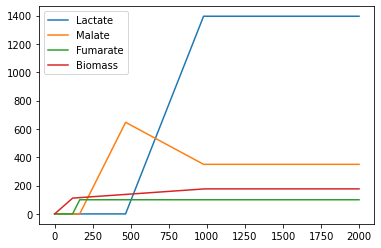

In [17]:
rate[['Lactate','Malate','Fumarate', 'Biomass']].plot()